# Blobs Circles Moons strawberry fields

In [1]:
from qutip import destroy
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors, colorbar, cm
import time
from tqdm.notebook import tqdm

1-moodeののQNNを構成する

In [2]:
def one_mode_variational_quantum_circuit_cubic(params, depth, input_state=None):
    # Gate layer: R-S-R-D-K
    def layer(i, q):
        Rgate(params[i*7+0])                | q
        Sgate(params[i*7+1], params[i*7+2]) | q
        Rgate(params[i*7+3])                | q
        Dgate(params[i*7+4], params[i*7+5]) | q
        Vgate(params[i*7+6])                | q
        return q
    
    # Start SF program
    prog = sf.Program(1)

    # construct the circuit
    with prog.context as q:
        if input_state is not None:
            Ket(input_state) | q
        else:
            Vacuum() | q
        for k in range(depth):
            q = layer(k, q)
    
    eng = sf.Engine("fock", backend_options={"cutoff_dim": dim})
    state = eng.run(prog).state
    ket = state.ket()
    return ket

In [3]:
def one_mode_U(x1_0, x2_0):
    x = np.array([x1_0, x2_0])
    params = (x @ u + v) / 1
    phi = one_mode_variational_quantum_circuit_cubic(params, depth_U)
    return phi

def one_mode_expect_Fock(psi):
    n = np.zeros(dim)
    prob = np.real(np.conjugate(psi) * psi)
    fock_basis = np.arange(dim)
    '''
    prob_posi = 0
    prob_nega = 0
    for i in range(dim):
        if i % 2 == 0:
            prob_posi += prob[i]
        else:
            prob_nega += prob[i]
    '''
    return np.sum(fock_basis * prob) #, prob_posi, prob_nega

def one_mode_expect_X(psi):
    # 測定用の演算子
    x = 1/np.sqrt(2) * (adag + a)
    
    # それぞれのモードをx = 1/√2 (a† + a)で測定
    expect_value = np.conjugate(psi.T) @ x @ psi
    return expect_value

Cost関数を定義。ここではbinary cross entropyとする。

$C(\theta) = -1/N \sum_{n=1}^{N} [t_n \log{y_n} + (1 - t_n) \log{(1 - y_n)}]$

$t_n$は正解の0,1、$y_n$は分類器によって出力された0,1

In [4]:
def discriminator(x1_0, x2_0, params):
    phi = one_mode_U(x1_0, x2_0)
    state = one_mode_variational_quantum_circuit_cubic(params, depth, phi)
    expect_value = one_mode_expect_Fock(state)

    # シグモイド関数により0 - 1にする
    result = 1 / (1 + np.exp(10*(params[7*depth] - expect_value)))
    return result
    
def get_cost(y, t):
    delta = 1e-12 # logの中身が0にならないようにするため
    return -np.sum(t * np.log(y+delta) + (1-t) * np.log(1-y+delta)) / len(y)

def cost(params):
    y = np.zeros(len(t))
    for i in range(len(t)):
        y[i] = discriminator(x1[i], x2[i], params)
    c = get_cost(y, t)
    return c

# callback用の関数
def callback(params):
    params_history.append(params)
    co = cost(params)
    cost_history.append(co)
    print(len(cost_history)-1,'cost', co)

In [17]:
dim = 50
_a = destroy(dim)
a = _a.full()
adag = np.conjugate(a.T)

depth_U = 1
depth_V = 1

# パラメータの決定
g = 1
#np.random.seed(1)
u = (g*np.random.rand(2,7*depth_U) - g/2) / 1
v = (g*np.random.rand(7*depth_U) - g/2) / 1
'''
u = np.array([[-0.49201056,  0.46031398,  0.11182869, -0.36183352,  0.2961122,   0.26468657,
  -0.44251039],
 [ 0.0359517,   0.16110539 , 0.11427918,  0.18337387, -0.00461446, -0.23381862,
  -0.10574061]])
v = np.array([ 0.09133706, -0.36032127, -0.18590361,  0.11834946, -0.15407532,  0.11210203,
 -0.44292793])
'''
print('u',u)
print('v',v)

u [[ 0.43850091 -0.08240727 -0.20858149  0.11502725 -0.43303765  0.27727129
   0.46762725]
 [-0.2869331  -0.15892388  0.20760404 -0.17663387 -0.41519595 -0.36893826
  -0.05766338]]
v [ 0.47610275  0.42101565 -0.39993243 -0.31259668  0.37989942  0.24049534
 -0.30944022]


## Moons

[-0.29029155  0.3456798   0.47916806 -1.03727167  1.23047539  0.57319032
  0.84445679  1.03043774 -0.8683864   0.43467891 -0.25779211 -0.06380638
  0.88465564  0.19693141 -0.92806637  0.63697653  0.60432816  0.70826732
  0.61294293 -0.00410577 -1.00634662 -0.81896547 -0.63945885  0.89675433
 -0.19732942  0.85148424  0.47775303 -0.88271286 -0.01009895  0.5410771
 -0.49504722 -0.77188558  0.27333581  0.64996669  0.96953943 -0.07126385
 -0.70972406 -0.09525888 -0.83394716  0.90187187 -0.97813319 -1.05216207
 -0.92084284  1.04835153 -0.73226442  0.25473738 -0.85400026  0.45907629
 -0.79158713  0.63764944 -0.06302218  1.81106918  2.04225275  1.8000829
  1.44904639  0.02948083  0.30019474  1.36427172  0.53047052  1.26207055
  1.96326895  1.41790883  1.9996195   1.75712895  1.88551312  1.68086865
  1.67317114  0.0853685  -0.03148348  2.12683121 -0.0459764   1.94445766
  0.35221223  0.03906502  0.00564964  1.70237421  1.65460849  0.04762763
  2.02780341  0.55131617  0.13522648  0.39260198  0.0

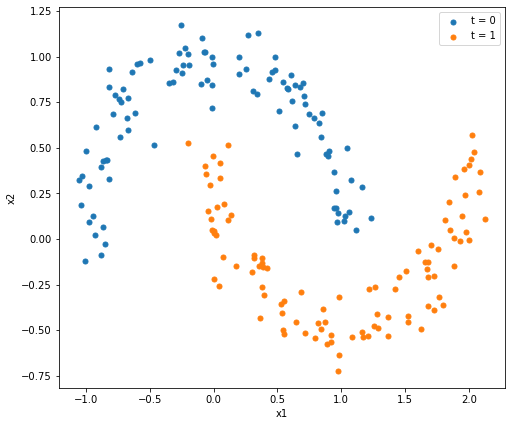

In [18]:
from sklearn.datasets import make_moons

n_each_data_train = 50
n_each_data_test = 50
 
x, y = make_moons(n_samples=2*(n_each_data_train+n_each_data_test), shuffle = True,
                  noise=0.1, random_state=True,)

x1_t0, x2_t0 = x[y==0,0], x[y==0,1]
x1_t1, x2_t1 = x[y==1,0], x[y==1,1]

x1_t0_train = x1_t0[0:n_each_data_train]
x2_t0_train = x2_t0[0:n_each_data_train]
x1_t1_train = x1_t1[0:n_each_data_train]
x2_t1_train = x2_t1[0:n_each_data_train]

x1_t0_test = x1_t0[n_each_data_train:n_each_data_train+n_each_data_test]
x2_t0_test = x2_t0[n_each_data_train:n_each_data_train+n_each_data_test]
x1_t1_test = x1_t1[n_each_data_train:n_each_data_train+n_each_data_test]
x2_t1_test = x2_t1[n_each_data_train:n_each_data_train+n_each_data_test]

t0_train, t1_train = np.zeros(n_each_data_train), np.ones(n_each_data_train)
t0_test, t1_test = np.zeros(n_each_data_test), np.ones(n_each_data_test)

x1 = np.concatenate([x1_t0_train, x1_t1_train])
x2 = np.concatenate([x2_t0_train, x2_t1_train])
t = np.concatenate([t0_train, t1_train])

x1_test = np.concatenate([x1_t0_test, x1_t1_test])
x2_test = np.concatenate([x2_t0_test, x2_t1_test])
t_test = np.concatenate([t0_test, t1_test])

print(x1)
print(t)

plt.figure(figsize=(8, 7))
 
plt.scatter(x1_t0, x2_t0, marker='o', s=25, label="t = 0")
plt.scatter(x1_t1, x2_t1, marker='o', s=25, label="t = 1")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

1 cost 1.3488193114770146
2 cost 1.2430388234832306
3 cost 1.0734784649163904
4 cost 0.9650035745185005
5 cost 0.7661514589201431
6 cost 0.5234552028390919
7 cost 0.37585724466152115
8 cost 0.31622525708430127
9 cost 0.24165283081675973
10 cost 0.19581839067419246
11 cost 0.18414020187955008
12 cost 0.1735587076010086
13 cost 0.1689126590631057
14 cost 0.16153037388999722
15 cost 0.15035577561722635
16 cost 0.14054395849371787
17 cost 0.12878519199576582
18 cost 0.11966929338823844
19 cost 0.10134885263750337
20 cost 0.09496872660442629
21 cost 0.09412828418260227
22 cost 0.08682575518912429
23 cost 0.0760132009452873
24 cost 0.06992204738734413
25 cost 0.0676172941615202
26 cost 0.06373890252043131
27 cost 0.061121755646047576
28 cost 0.0580052183894978
29 cost 0.05628686842712363
30 cost 0.05580756229548504
31 cost 0.05565208479935763
32 cost 0.055486684735660007
33 cost 0.05540469107147525
34 cost 0.055263900326132404
35 cost 0.055019199185377746
36 cost 0.054495873897143665
37 cost

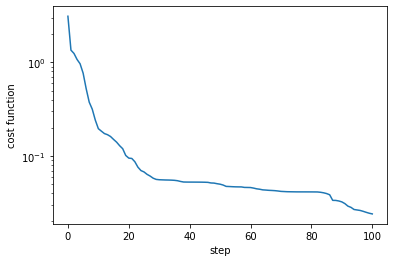

In [19]:
depth = 1

# 学習
params = np.random.normal(0, 0.1, [7*depth + 1]) # 最初のパラメータ
maxiter = 100

params_history = []
params_history.append(params)
cost_history = []
cost_history.append(cost(params))

method = "BFGS"
options = {"disp": True, "maxiter": maxiter}

start = time.perf_counter()
opt = scipy.optimize.minimize(cost, params, method=method,
                              callback=lambda x: callback(x), options=options)
end = time.perf_counter()

print('time', end - start, 's')
nit = opt['nit']
plt.plot(np.linspace(0, nit, nit+1), cost_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('cost function')
plt.show()

In [20]:
print('initial parameters:', params_history[0])
print('learnt_parameters:', params_history[-1])

print('-------------------------------')
print('train dataset')

learnt_label_train = np.array([0.0 for i in range(len(t))])
for i in range(len(learnt_label_train)):
    learnt_label_train[i] = discriminator(x1[i], x2[i], params_history[-1])
learnt_label_train = np.round(learnt_label_train).astype(int)
n_miss_train = sum(abs(t - learnt_label_train))
t = t.astype(int)

print('teacher label', t)
print('learnt label ', learnt_label_train)
print('number of mislabel:', n_miss_train)

print('-------------------------------')
print('test dataset')

learnt_label_test = np.array([0.0 for i in range(len(t_test))])
for i in range(len(learnt_label_test)):
    learnt_label_test[i] = discriminator(x1_test[i], x2_test[i], params_history[-1])
learnt_label_test = np.round(learnt_label_test).astype(int)
n_miss_test = sum(abs(t_test - learnt_label_test))
t_test = t_test.astype(int)

print('teacher label', t_test)
print('learnt label ',learnt_label_test)
print('number of mislabel:', n_miss_test)

initial parameters: [ 0.05754508 -0.08629276  0.11298462 -0.15267042  0.06580368 -0.04502428
  0.07229795 -0.0570869 ]
learnt_parameters: [-4.06215077  1.23163464 -9.91093203  4.86303663  0.70067597  1.81575965
  6.35614786  4.54954638]
-------------------------------
train dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of mislabel: 1.0
-------------------------------
test dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/100 [00:00<?, ?it/s]

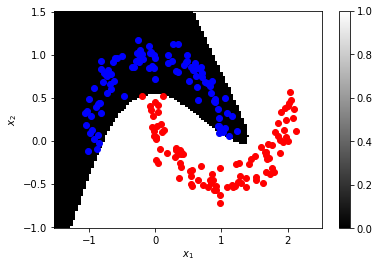

In [21]:
x1_lin = np.linspace(-1.5, 2.5, 100)
x2_lin = np.linspace(-1, 1.5, 100)
learnt_label = np.zeros((len(x1_lin), len(x2_lin)))
value = np.zeros_like(learnt_label)
for i in tqdm(range(len(x1_lin))):
    for j in range(len(x2_lin)):
        value[j,i] = discriminator(x1_lin[i], x2_lin[j], params_history[-1])
        if value[j,i] > 0.5:
            learnt_label[j,i] = 1
        else:
            learnt_label[j,i] = 0

plt.pcolor(x1_lin, x2_lin, learnt_label, shading="nearest", cmap="gray")
plt.colorbar()
plt.scatter(x1_t0, x2_t0, color='blue')
plt.scatter(x1_t1, x2_t1, color='red')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

## Blobs

[ 4.44097997e-01  1.83773582e-01  2.92533998e-01  1.12471455e+00
  9.45121887e-01  3.47186679e-01  4.60360226e-01 -2.35350010e-01
  8.29560666e-01  9.08591004e-02  2.35299052e-01  3.29843646e-01
 -5.07217751e-01  1.01457075e+00 -1.14082639e-01  9.25900977e-01
 -2.20061366e-03  1.06207278e+00  4.09271686e-01  9.99162743e-01
  2.42687954e-01  4.69258545e-01 -9.49889850e-01  1.03205278e+00
  2.06536474e-01  1.50222387e+00 -1.02471934e-01  4.86069941e-01
  7.26952331e-01  1.31311629e-01  8.80507159e-01  1.49966127e-01
  1.06996801e+00  5.84451877e-01  5.09201107e-01  1.68872686e-01
  2.13728216e-01  8.20601509e-01 -1.89902726e-01  1.62998687e-01
 -3.91354422e-03  2.45346703e-01  5.80510633e-01  1.02745508e+00
  7.87335628e-01  4.43298521e-01  1.37268774e+00  1.70615271e-01
  7.68247823e-02  8.31893924e-01 -2.10534543e+00 -1.08112729e+00
 -1.91554469e+00 -2.73406727e+00 -1.55734484e+00 -3.06348874e+00
 -1.88176210e+00 -2.04847058e+00 -2.05140651e+00 -2.04543536e+00
 -2.04642593e+00 -1.89438

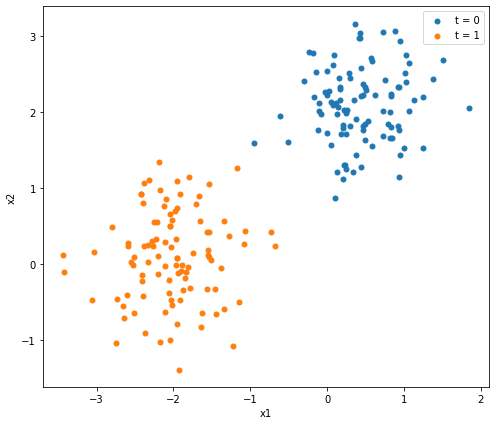

In [22]:
from sklearn.datasets import make_blobs

n_each_data_train = 50
n_each_data_test = 50
 
x, y = make_blobs(n_samples=2*(n_each_data_train+n_each_data_test), n_features=2, centers=2, 
                  cluster_std=0.5, center_box=(-5.0,5.0), shuffle=True, random_state=3,)

x1_t0, x2_t0 = x[y==0,0], x[y==0,1]
x1_t1, x2_t1 = x[y==1,0], x[y==1,1]

x1_t0_train = x1_t0[0:n_each_data_train]
x2_t0_train = x2_t0[0:n_each_data_train]
x1_t1_train = x1_t1[0:n_each_data_train]
x2_t1_train = x2_t1[0:n_each_data_train]

x1_t0_test = x1_t0[n_each_data_train:n_each_data_train+n_each_data_test]
x2_t0_test = x2_t0[n_each_data_train:n_each_data_train+n_each_data_test]
x1_t1_test = x1_t1[n_each_data_train:n_each_data_train+n_each_data_test]
x2_t1_test = x2_t1[n_each_data_train:n_each_data_train+n_each_data_test]

t0_train, t1_train = np.zeros(n_each_data_train), np.ones(n_each_data_train)
t0_test, t1_test = np.zeros(n_each_data_test), np.ones(n_each_data_test)

x1 = np.concatenate([x1_t0_train, x1_t1_train])
x2 = np.concatenate([x2_t0_train, x2_t1_train])
t = np.concatenate([t0_train, t1_train])

x1_test = np.concatenate([x1_t0_test, x1_t1_test])
x2_test = np.concatenate([x2_t0_test, x2_t1_test])
t_test = np.concatenate([t0_test, t1_test])

print(x1)
print(t)

plt.figure(figsize=(8, 7))
 
plt.scatter(x1_t0, x2_t0, marker='o', s=25, label="t = 0")
plt.scatter(x1_t1, x2_t1, marker='o', s=25, label="t = 1")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

1 cost 0.6290411445265331
2 cost 0.3683598031517619
3 cost 0.2620479551681123
4 cost 0.14261612938507348
5 cost 0.10792263602364763
6 cost 0.05325053492394152
7 cost 0.025084841783995313
8 cost 0.011611227593632756
9 cost 0.0032925348021670027
10 cost 0.002040126931041781
11 cost 0.001057162509190959
12 cost 0.0006166620829519055
13 cost 0.0003609063074740786
14 cost 0.00022243352683559575
15 cost 0.0001522901084177009
16 cost 0.0001366408706859382
17 cost 0.00011956605074702423
18 cost 9.57738180664704e-05
19 cost 8.859275211801717e-05
20 cost 8.692764267063672e-05
21 cost 8.481575896911949e-05
22 cost 8.113456088035307e-05
23 cost 7.458594282324235e-05
24 cost 6.320159061377377e-05
25 cost 4.492330835457307e-05
26 cost 2.5385442347891008e-05
27 cost 1.4078579874999502e-05
28 cost 6.883512694109119e-06
29 cost 3.0107708216788206e-06
30 cost 1.4980277253062824e-06
31 cost 9.792099130377636e-07
32 cost 7.149222266448509e-07
33 cost 4.886380398046159e-07
34 cost 1.9118704795390073e-07
35

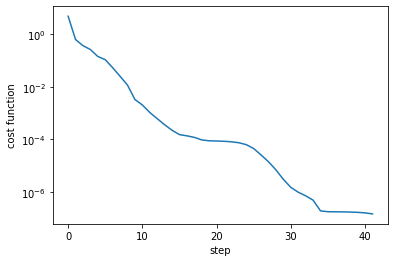

In [23]:
depth = 1

# 学習
params = np.random.normal(0, 0.1, [7*depth + 1]) # 最初のパラメータ
maxiter = 100

params_history = []
params_history.append(params)
cost_history = []
cost_history.append(cost(params))

method = "BFGS"
options = {"disp": True, "maxiter": maxiter}

start = time.perf_counter()
opt = scipy.optimize.minimize(cost, params, method=method,
                              callback=lambda x: callback(x), options=options)
end = time.perf_counter()

print('time', end - start, 's')
nit = opt['nit']
plt.plot(np.linspace(0, nit, nit+1), cost_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('cost function')
plt.show()

In [24]:
print('initial parameters:', params_history[0])
print('learnt_parameters:', params_history[-1])

print('-------------------------------')
print('train dataset')

learnt_label_train = np.array([0.0 for i in range(len(t))])
for i in range(len(learnt_label_train)):
    learnt_label_train[i] = discriminator(x1[i], x2[i], params_history[-1])
learnt_label_train = np.round(learnt_label_train).astype(int)
n_miss_train = sum(abs(t - learnt_label_train))
t = t.astype(int)

print('teacher label', t)
print('learnt label ', learnt_label_train)
print('number of mislabel:', n_miss_train)

print('-------------------------------')
print('test dataset')

learnt_label_test = np.array([0.0 for i in range(len(t_test))])
for i in range(len(learnt_label_test)):
    learnt_label_test[i] = discriminator(x1_test[i], x2_test[i], params_history[-1])
learnt_label_test = np.round(learnt_label_test).astype(int)
n_miss_test = sum(abs(t_test - learnt_label_test))
t_test = t_test.astype(int)

print('teacher label', t_test)
print('learnt label ',learnt_label_test)
print('number of mislabel:', n_miss_test)

initial parameters: [ 0.00663932  0.14379017  0.06598695 -0.01028692 -0.1418387  -0.06650375
  0.02874182 -0.12619529]
learnt_parameters: [-2.35053151e-01  5.62435792e-01  5.64241303e-01  2.30829114e-03
 -9.92056585e-02  1.27793806e-01 -6.04099954e-01  3.74278207e+00]
-------------------------------
train dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of mislabel: 0.0
-------------------------------
test dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1

  0%|          | 0/100 [00:00<?, ?it/s]

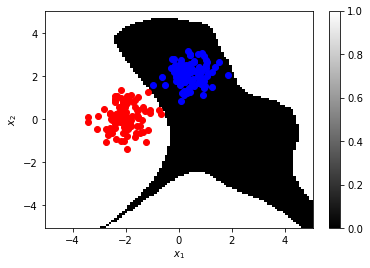

In [25]:
x1_lin = np.linspace(-3.5, 2, 100)
x2_lin = np.linspace(-1.5, 3.5, 100)
learnt_label = np.zeros((len(x1_lin), len(x2_lin)))
value = np.zeros_like(learnt_label)
for i in tqdm(range(len(x1_lin))):
    for j in range(len(x2_lin)):
        value[j,i] = discriminator(x1_lin[i], x2_lin[j], params_history[-1])
        if value[j,i] > 0.5:
            learnt_label[j,i] = 1
        else:
            learnt_label[j,i] = 0

plt.pcolor(x1_lin, x2_lin, learnt_label, shading="nearest", cmap="gray")
plt.colorbar()
plt.scatter(x1_t0, x2_t0, color='blue')
plt.scatter(x1_t1, x2_t1, color='red')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

## Circles

[-0.03190127  0.08274053 -0.16058388  0.21113828 -0.00505293 -0.15642995
  0.16609505  0.08273599 -0.18499502 -0.1427308  -0.17153917  0.09551509
 -0.10491614 -0.00713407 -0.14732465 -0.49370938 -0.02084201 -0.11415317
 -0.15729459  0.05505298  0.05868738 -0.11744406 -0.06106753 -0.10070878
 -0.01960367 -0.03171476 -0.57959966  0.19682313  0.21265156  0.0786386
 -0.04619745  0.29571994 -0.02663912 -0.2246165   0.0162749   0.16937464
 -0.24716181  0.04931894  0.17050611  0.29897871  0.08792805  0.05344897
  0.10008946  0.31092548  0.01378217 -0.17504021 -0.05402217 -0.25082317
 -0.18503418 -0.25200824 -0.94465953 -1.14869369  0.39216127 -0.85684052
 -0.40046915  0.50735524 -0.14320516  0.70687613  0.98277608 -0.98941462
 -0.90443069  0.47824105  1.26419112  0.63244487  0.84521441 -0.2915405
 -1.08451305 -0.73989865 -0.59940267  0.94303075 -0.09822512 -0.08405574
  0.81723821 -0.69286316  0.34321514 -0.46322952  0.73697352  0.42683365
  0.25335868  0.08567518  0.08810988 -0.02790555  0.3

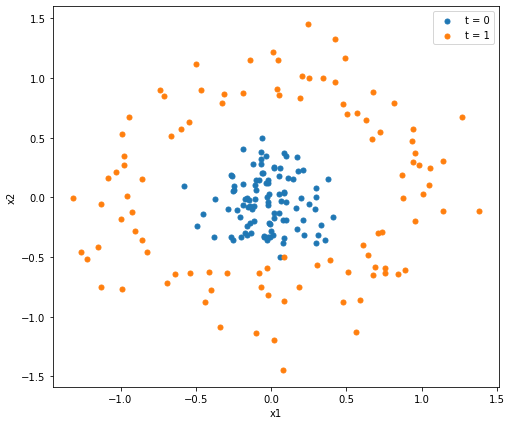

In [26]:
from sklearn.datasets import make_circles

n_each_data_train = 50
n_each_data_test = 50
 
x, y = make_circles(n_samples=2*(n_each_data_train+n_each_data_test), shuffle=True, noise = 0.2, 
                    random_state=3, factor=0.1)

x1_t0, x2_t0 = x[y==1,0], x[y==1,1]
x1_t1, x2_t1 = x[y==0,0], x[y==0,1]

x1_t0_train = x1_t0[0:n_each_data_train]
x2_t0_train = x2_t0[0:n_each_data_train]
x1_t1_train = x1_t1[0:n_each_data_train]
x2_t1_train = x2_t1[0:n_each_data_train]

x1_t0_test = x1_t0[n_each_data_train:n_each_data_train+n_each_data_test]
x2_t0_test = x2_t0[n_each_data_train:n_each_data_train+n_each_data_test]
x1_t1_test = x1_t1[n_each_data_train:n_each_data_train+n_each_data_test]
x2_t1_test = x2_t1[n_each_data_train:n_each_data_train+n_each_data_test]

t0_train, t1_train = np.zeros(n_each_data_train), np.ones(n_each_data_train)
t0_test, t1_test = np.zeros(n_each_data_test), np.ones(n_each_data_test)

x1 = np.concatenate([x1_t0_train, x1_t1_train])
x2 = np.concatenate([x2_t0_train, x2_t1_train])
t = np.concatenate([t0_train, t1_train])

x1_test = np.concatenate([x1_t0_test, x1_t1_test])
x2_test = np.concatenate([x2_t0_test, x2_t1_test])
t_test = np.concatenate([t0_test, t1_test])

print(x1)
print(t)

plt.figure(figsize=(8, 7))
 
plt.scatter(x1_t0, x2_t0, marker='o', s=25, label="t = 0")
plt.scatter(x1_t1, x2_t1, marker='o', s=25, label="t = 1")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

1 cost 0.9450733964854521
2 cost 0.5304859999834993
3 cost 0.45950245141587603
4 cost 0.4159376514125389
5 cost 0.3961104233120545
6 cost 0.3687974280928467
7 cost 0.32918413536902025
8 cost 0.3156941692362028
9 cost 0.2989535571522099
10 cost 0.2838008984208515
11 cost 0.276879622019449
12 cost 0.26591123242006715
13 cost 0.25025365929946564
14 cost 0.239414441254861
15 cost 0.22772204621601422
16 cost 0.22666817660238997
17 cost 0.22494303686139777
18 cost 0.22212156204197575
19 cost 0.21779477142061843
20 cost 0.212115348900843
21 cost 0.20256634334241547
22 cost 0.18535552460070404
23 cost 0.17375996725801013
24 cost 0.16021715556620653
25 cost 0.15384577230642346
26 cost 0.15067356258413503
27 cost 0.1469435803973302
28 cost 0.14521639022823082
29 cost 0.142513877021876
30 cost 0.13959635640019905
31 cost 0.13672085869605877
32 cost 0.1322850773444503
33 cost 0.12578491715871495
34 cost 0.12138109765471664
35 cost 0.11410789543927176
36 cost 0.10617480603542248
37 cost 0.099203926

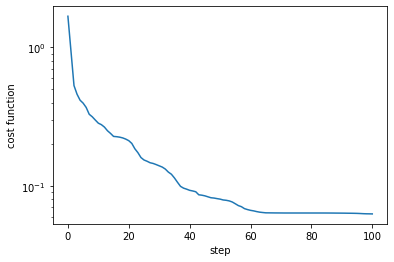

In [27]:
depth = 1

# 学習
params = np.random.normal(0, 0.1, [7*depth + 1]) # 最初のパラメータ
maxiter = 100

params_history = []
params_history.append(params)
cost_history = []
cost_history.append(cost(params))

method = "BFGS"
options = {"disp": True, "maxiter": maxiter}

start = time.perf_counter()
opt = scipy.optimize.minimize(cost, params, method=method,
                              callback=lambda x: callback(x), options=options)
end = time.perf_counter()

print('time', end - start, 's')
nit = opt['nit']
plt.plot(np.linspace(0, nit, nit+1), cost_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('cost function')
plt.show()

In [28]:
print('initial parameters:', params_history[0])
print('learnt_parameters:', params_history[-1])

print('-------------------------------')
print('train dataset')

learnt_label_train = np.array([0.0 for i in range(len(t))])
for i in range(len(learnt_label_train)):
    learnt_label_train[i] = discriminator(x1[i], x2[i], params_history[-1])
learnt_label_train = np.round(learnt_label_train).astype(int)
n_miss_train = sum(abs(t - learnt_label_train))
t = t.astype(int)

print('teacher label', t)
print('learnt label ', learnt_label_train)
print('number of mislabel:', n_miss_train)

print('-------------------------------')
print('test dataset')

learnt_label_test = np.array([0.0 for i in range(len(t_test))])
for i in range(len(learnt_label_test)):
    learnt_label_test[i] = discriminator(x1_test[i], x2_test[i], params_history[-1])
learnt_label_test = np.round(learnt_label_test).astype(int)
n_miss_test = sum(abs(t_test - learnt_label_test))
t_test = t_test.astype(int)

print('teacher label', t_test)
print('learnt label ',learnt_label_test)
print('number of mislabel:', n_miss_test)

initial parameters: [ 0.01302884  0.00653518 -0.02140593 -0.12317383  0.04460896 -0.15475837
  0.07742512  0.00507051]
learnt_parameters: [-0.11615354 -1.19413608 -0.39810006 -1.09980372 -0.92421184  1.48313568
  3.32976866  3.81909046]
-------------------------------
train dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of mislabel: 2.0
-------------------------------
test dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/100 [00:00<?, ?it/s]

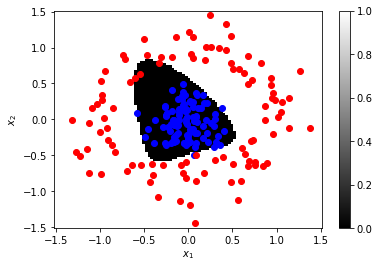

In [29]:
x1_lin = np.linspace(-1.5, 1.5, 100)
x2_lin = np.linspace(-1.5, 1.5, 100)
learnt_label = np.zeros((len(x1_lin), len(x2_lin)))
value = np.zeros_like(learnt_label)
for i in tqdm(range(len(x1_lin))):
    for j in range(len(x2_lin)):
        value[j,i] = discriminator(x1_lin[i], x2_lin[j], params_history[-1])
        if value[j,i] > 0.5:
            learnt_label[j,i] = 1
        else:
            learnt_label[j,i] = 0

plt.pcolor(x1_lin, x2_lin, learnt_label, shading="nearest", cmap="gray")
plt.colorbar()
plt.scatter(x1_t0, x2_t0, color='blue')
plt.scatter(x1_t1, x2_t1, color='red')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()